In [67]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from datetime import datetime
from sklearn import preprocessing

# Arguments

In [68]:
args = {'noise':0.01,
        'percent training data':0.7,
        'spec scale':10**12,
        'correlation':0,

        'forward learning rate':0.01,
        'inverse learning rate':0.01,

        'forward training epochs':1000,
        'inverse training epochs':5000,

        'forward training criterion':nn.L1Loss(),
        'inverse training criterion':nn.L1Loss(),
        'testing criterion':nn.L1Loss(),
        
        'optimizer':torch.optim.Rprop,

        'percent inverse':0.65
        }

now = datetime.now()

# Data Prep

In [69]:
# fn to convert dataframes to tensors
def df_to_tensor(df):
    return torch.tensor(df.values, dtype=torch.float32)

In [70]:
df = pd.read_excel('data_3nm.xlsx')

spec = df.iloc[:,11:] 
temp = df.iloc[:,:11]

In [71]:
spec

,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,...,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008
0,3.105584e-14,3.052205e-14,4.107059e-14,4.675147e-14,3.859431e-14,2.935851e-14,3.151355e-14,4.473981e-14,4.390755e-14,3.170344e-14,...,2.255215e-12,2.250856e-12,2.246458e-12,2.242043e-12,2.237622e-12,2.233144e-12,2.228542e-12,2.223762e-12,2.218939e-12,2.214334e-12
1,2.303472e-14,2.243980e-14,2.986917e-14,3.394207e-14,2.823448e-14,2.151428e-14,2.288213e-14,3.211078e-14,3.169674e-14,2.301430e-14,...,1.636173e-12,1.633204e-12,1.630206e-12,1.627196e-12,1.624179e-12,1.621120e-12,1.617971e-12,1.614691e-12,1.611379e-12,1.608225e-12
2,3.321009e-14,3.183994e-14,4.156518e-14,4.707322e-14,3.965683e-14,3.022635e-14,3.161482e-14,4.346603e-14,4.329419e-14,3.168369e-14,...,4.265080e-12,4.255842e-12,4.246534e-12,4.237201e-12,4.227860e-12,4.218417e-12,4.208743e-12,4.198740e-12,4.188660e-12,4.178998e-12
3,1.357453e-14,1.306165e-14,1.711864e-14,1.942411e-14,1.632974e-14,1.246013e-14,1.307745e-14,1.806431e-14,1.797263e-14,1.314374e-14,...,2.689740e-12,2.684366e-12,2.678947e-12,2.673510e-12,2.668065e-12,2.662553e-12,2.656894e-12,2.651024e-12,2.645104e-12,2.639444e-12
4,2.619885e-14,2.531656e-14,3.336945e-14,3.787416e-14,3.170747e-14,2.416178e-14,2.548633e-14,3.541894e-14,3.511435e-14,2.559810e-14,...,3.023923e-12,3.017753e-12,3.011531e-12,3.005289e-12,2.999040e-12,2.992716e-12,2.986228e-12,2.979503e-12,2.972721e-12,2.966234e-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2195,2.956149e-14,2.846418e-14,3.735680e-14,4.237698e-14,3.557164e-14,2.710359e-14,2.848041e-14,3.940371e-14,3.914222e-14,2.857967e-14,...,4.376826e-12,4.367304e-12,4.357712e-12,4.348093e-12,4.338467e-12,4.328736e-12,4.318769e-12,4.308464e-12,4.298080e-12,4.288126e-12
2196,3.749401e-14,3.641635e-14,4.832023e-14,5.488017e-14,4.572003e-14,3.481850e-14,3.692342e-14,5.165697e-14,5.104080e-14,3.708188e-14,...,3.737057e-12,3.729141e-12,3.721165e-12,3.713165e-12,3.705158e-12,3.697059e-12,3.688758e-12,3.680167e-12,3.671508e-12,3.663214e-12
2197,2.472354e-14,2.407549e-14,3.204759e-14,3.642555e-14,3.030117e-14,2.307305e-14,2.453848e-14,3.444697e-14,3.399959e-14,2.467478e-14,...,3.172314e-12,3.165785e-12,3.159202e-12,3.152599e-12,3.145989e-12,3.139300e-12,3.132439e-12,3.125330e-12,3.118162e-12,3.111303e-12
2198,3.013358e-14,2.888866e-14,3.770118e-14,4.269718e-14,3.597842e-14,2.743253e-14,2.868471e-14,3.942280e-14,3.927214e-14,2.875220e-14,...,3.383006e-12,3.375964e-12,3.368865e-12,3.361745e-12,3.354617e-12,3.347406e-12,3.340011e-12,3.332353e-12,3.324633e-12,3.317242e-12


In [72]:
# scale spectrum data by 10^12
spec = spec.apply(lambda x: x*args['spec scale'])

In [73]:
spec

,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,...,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008
0,0.031056,0.030522,0.041071,0.046751,0.038594,0.029359,0.031514,0.044740,0.043908,0.031703,...,2.255215,2.250856,2.246458,2.242043,2.237622,2.233144,2.228542,2.223762,2.218939,2.214334
1,0.023035,0.022440,0.029869,0.033942,0.028234,0.021514,0.022882,0.032111,0.031697,0.023014,...,1.636173,1.633204,1.630206,1.627196,1.624179,1.621120,1.617971,1.614691,1.611379,1.608225
2,0.033210,0.031840,0.041565,0.047073,0.039657,0.030226,0.031615,0.043466,0.043294,0.031684,...,4.265080,4.255842,4.246534,4.237201,4.227860,4.218417,4.208743,4.198740,4.188660,4.178998
3,0.013575,0.013062,0.017119,0.019424,0.016330,0.012460,0.013077,0.018064,0.017973,0.013144,...,2.689740,2.684366,2.678947,2.673510,2.668065,2.662553,2.656894,2.651024,2.645104,2.639444
4,0.026199,0.025317,0.033369,0.037874,0.031707,0.024162,0.025486,0.035419,0.035114,0.025598,...,3.023923,3.017753,3.011531,3.005289,2.999040,2.992716,2.986228,2.979503,2.972721,2.966234
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2195,0.029561,0.028464,0.037357,0.042377,0.035572,0.027104,0.028480,0.039404,0.039142,0.028580,...,4.376826,4.367304,4.357712,4.348093,4.338467,4.328736,4.318769,4.308464,4.298080,4.288126
2196,0.037494,0.036416,0.048320,0.054880,0.045720,0.034819,0.036923,0.051657,0.051041,0.037082,...,3.737057,3.729141,3.721165,3.713165,3.705158,3.697059,3.688758,3.680167,3.671508,3.663214
2197,0.024724,0.024075,0.032048,0.036426,0.030301,0.023073,0.024538,0.034447,0.034000,0.024675,...,3.172314,3.165785,3.159202,3.152599,3.145989,3.139300,3.132439,3.125330,3.118162,3.111303
2198,0.030134,0.028889,0.037701,0.042697,0.035978,0.027433,0.028685,0.039423,0.039272,0.028752,...,3.383006,3.375964,3.368865,3.361745,3.354617,3.347406,3.340011,3.332353,3.324633,3.317242


In [74]:
# add noise
noise = np.random.normal(loc=0, scale=args['noise'], size=spec.shape)
spec_noisy = spec + noise

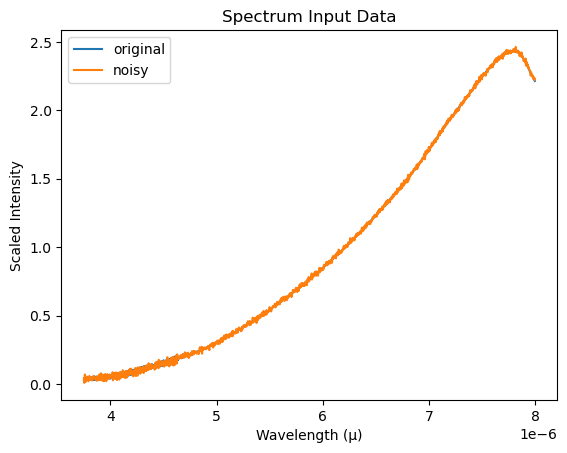

In [75]:
plt.title('Spectrum Input Data')
plt.plot(spec.iloc[0], label='original')
plt.plot(spec_noisy.iloc[0], label='noisy')
plt.xlabel("Wavelength (µ)")
plt.ylabel("Scaled Intensity")
plt.legend()
plt.show()

In [76]:
# Normalize clean and noisy spectrum data
spec_scaler = preprocessing.StandardScaler()

spec_scaler.fit(spec)
spec_scaled = spec_scaler.transform(spec)
spec_unscaled = spec_scaler.inverse_transform(spec_scaled)

spec_scaler.fit(spec_noisy)
spec_noisy_scaled = spec_scaler.transform(spec_noisy)

spec_scaled_df = pd.DataFrame(spec_scaled, columns=spec.columns)
spec_noisy_scaled_df = pd.DataFrame(spec_noisy_scaled, columns = spec.columns)



# Normalize clean and temperature data
temp_scaler = preprocessing.StandardScaler()
temp_scaler.fit(temp)
temp_scaled = temp_scaler.transform(temp)
temp_unscaled = temp_scaler.inverse_transform(temp_scaled)

temp_unscaled_df = pd.DataFrame(temp_unscaled, columns=temp.columns)
temp_scaled_df = pd.DataFrame(temp_scaled, columns=temp.columns)


/Users/aidenkarpf/anaconda3/lib/python3.10/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(
/Users/aidenkarpf/anaconda3/lib/python3.10/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(
/Users/aidenkarpf/anaconda3/lib/python3.10/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(
/Users/aidenkarpf/anaconda3/lib/python3.10/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(


In [77]:
spec

,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,...,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008
0,0.031056,0.030522,0.041071,0.046751,0.038594,0.029359,0.031514,0.044740,0.043908,0.031703,...,2.255215,2.250856,2.246458,2.242043,2.237622,2.233144,2.228542,2.223762,2.218939,2.214334
1,0.023035,0.022440,0.029869,0.033942,0.028234,0.021514,0.022882,0.032111,0.031697,0.023014,...,1.636173,1.633204,1.630206,1.627196,1.624179,1.621120,1.617971,1.614691,1.611379,1.608225
2,0.033210,0.031840,0.041565,0.047073,0.039657,0.030226,0.031615,0.043466,0.043294,0.031684,...,4.265080,4.255842,4.246534,4.237201,4.227860,4.218417,4.208743,4.198740,4.188660,4.178998
3,0.013575,0.013062,0.017119,0.019424,0.016330,0.012460,0.013077,0.018064,0.017973,0.013144,...,2.689740,2.684366,2.678947,2.673510,2.668065,2.662553,2.656894,2.651024,2.645104,2.639444
4,0.026199,0.025317,0.033369,0.037874,0.031707,0.024162,0.025486,0.035419,0.035114,0.025598,...,3.023923,3.017753,3.011531,3.005289,2.999040,2.992716,2.986228,2.979503,2.972721,2.966234
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2195,0.029561,0.028464,0.037357,0.042377,0.035572,0.027104,0.028480,0.039404,0.039142,0.028580,...,4.376826,4.367304,4.357712,4.348093,4.338467,4.328736,4.318769,4.308464,4.298080,4.288126
2196,0.037494,0.036416,0.048320,0.054880,0.045720,0.034819,0.036923,0.051657,0.051041,0.037082,...,3.737057,3.729141,3.721165,3.713165,3.705158,3.697059,3.688758,3.680167,3.671508,3.663214
2197,0.024724,0.024075,0.032048,0.036426,0.030301,0.023073,0.024538,0.034447,0.034000,0.024675,...,3.172314,3.165785,3.159202,3.152599,3.145989,3.139300,3.132439,3.125330,3.118162,3.111303
2198,0.030134,0.028889,0.037701,0.042697,0.035978,0.027433,0.028685,0.039423,0.039272,0.028752,...,3.383006,3.375964,3.368865,3.361745,3.354617,3.347406,3.340011,3.332353,3.324633,3.317242


In [78]:
spec_unscaled

array([[0.03105584, 0.03052205, 0.04107059, ..., 2.2237618 , 2.21893855,
        2.21433401],
       [0.02303472, 0.0224398 , 0.02986917, ..., 1.61469112, 1.61137908,
        1.60822492],
       [0.03321009, 0.03183994, 0.04156518, ..., 4.19873996, 4.18865979,
        4.1789976 ],
       ...,
       [0.02472354, 0.02407549, 0.03204759, ..., 3.12532968, 3.11816178,
        3.11130323],
       [0.03013358, 0.02888866, 0.03770118, ..., 3.33235318, 3.3246326 ,
        3.31724227],
       [0.05867424, 0.05706454, 0.07582961, ..., 2.89888822, 2.89231923,
        2.88603676]])

In [79]:
spec_noisy_scaled_df    

,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,...,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008
0,1.301394,-1.168232,-0.182602,1.843959,0.314686,-0.576387,1.669527,-0.167739,1.102430,0.898858,...,-0.318087,-0.308628,-0.310389,-0.307077,-0.319400,-0.315709,-0.302753,-0.315224,-0.307009,-0.298552
1,0.128763,-1.568002,0.085828,-0.402522,0.612515,-0.731397,1.100422,-0.308215,-0.425880,-0.580780,...,-0.809123,-0.800609,-0.795539,-0.805230,-0.792756,-0.811871,-0.803688,-0.796051,-0.794502,-0.793422
2,0.621764,0.351394,-0.273611,-0.395051,1.530561,0.665199,0.222633,0.252281,1.358474,1.068908,...,1.277966,1.278227,1.295672,1.274032,1.271295,1.272926,1.282130,1.277518,1.267762,1.281662
3,0.080563,-0.160915,-0.444688,-1.853030,-2.335752,-0.936437,-0.865439,-1.612913,-1.713073,0.079227,...,0.026588,0.037200,0.035202,0.027972,0.026341,0.023753,0.039765,0.037590,0.019272,0.027266
4,0.548938,0.232699,-0.228281,-0.060614,0.220429,-0.091048,-0.181097,0.784700,-0.063238,-0.028188,...,0.300300,0.287191,0.302379,0.298740,0.300699,0.305832,0.291130,0.306041,0.295869,0.305114
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2195,-0.886072,0.619187,-0.148360,0.430433,0.009878,0.738081,0.341331,0.200412,-0.143103,0.238915,...,1.380680,1.369534,1.349017,1.361535,1.360693,1.375314,1.358868,1.371193,1.356974,1.365571
2196,1.094027,0.780489,0.962442,1.437985,1.309354,1.629360,1.419600,0.650965,1.012437,0.315033,...,0.852352,0.859731,0.859178,0.852936,0.861701,0.868589,0.859169,0.871759,0.857626,0.845697
2197,-0.803874,-0.515247,-0.010545,-0.523625,0.345532,0.033281,0.438597,-0.595107,-0.929671,-0.527212,...,0.420874,0.399675,0.407053,0.417527,0.417776,0.424829,0.418543,0.406480,0.417737,0.421091
2198,0.418029,-0.056323,0.813228,0.287338,0.799898,-1.127139,-0.076874,-0.049343,-0.242543,-1.054836,...,0.581038,0.581018,0.566188,0.569359,0.569712,0.573624,0.566067,0.576200,0.582725,0.580426


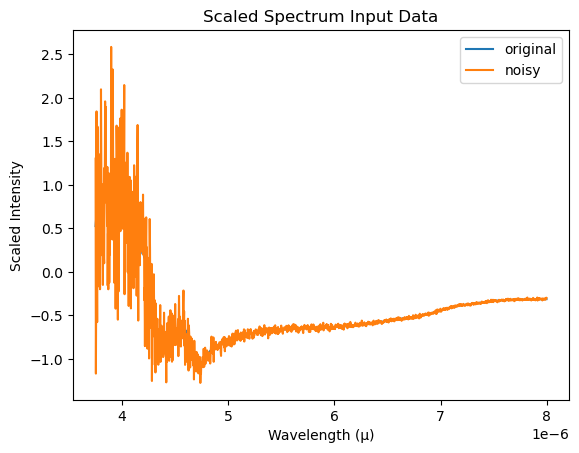

In [80]:
plt.title('Scaled Spectrum Input Data')
plt.plot(spec_scaled_df.iloc[0], label='original')
plt.plot(spec_noisy_scaled_df.iloc[0], label='noisy')
plt.xlabel("Wavelength (µ)")
plt.ylabel("Scaled Intensity")
plt.legend()
plt.show()

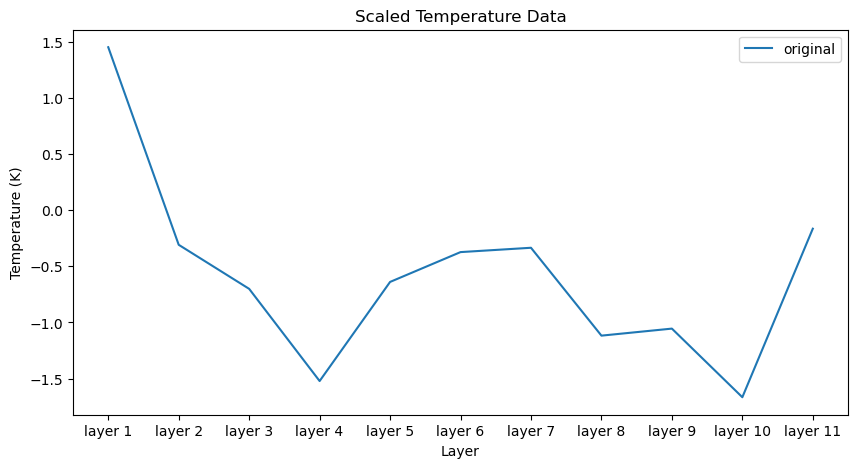

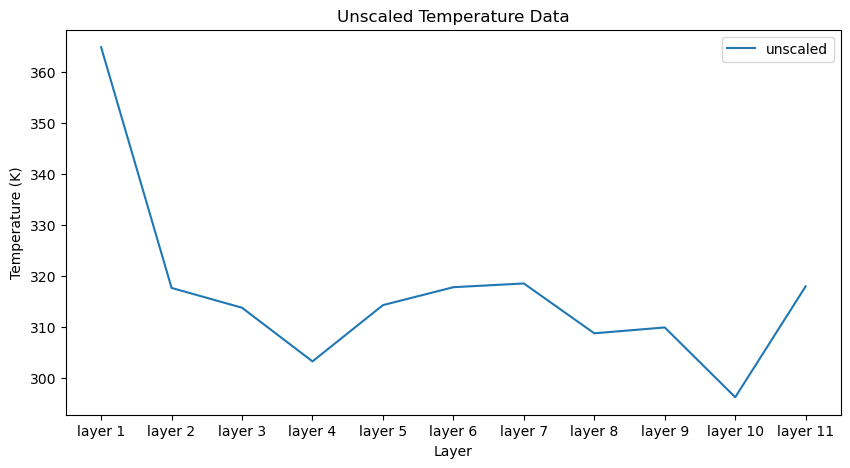

In [81]:
plt.figure(figsize=(10, 5))
plt.title('Scaled Temperature Data')
plt.plot(temp_scaled_df.iloc[0], label='original')
plt.xlabel("Layer")
plt.ylabel("Temperature (K)")
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.title('Unscaled Temperature Data')
plt.plot(temp_unscaled_df.iloc[0], label='unscaled')
plt.xlabel("Layer")
plt.ylabel("Temperature (K)")
plt.legend()
plt.show()

In [82]:
spec_train_df, spec_test_df, temp_train_df, temp_test_df = train_test_split(spec_noisy_scaled_df, temp_scaled_df, train_size=args['percent training data'], random_state=101)

spec_train = df_to_tensor(spec_train_df)
spec_test = df_to_tensor(spec_test_df)
temp_train = df_to_tensor(temp_train_df)
temp_test = df_to_tensor(temp_test_df)

In [83]:
# Feature Selection

In [84]:
spec_train

tensor([[-0.8918, -1.0454, -0.8408,  ..., -1.1233, -1.1295, -1.1221],
        [ 0.3569, -0.2189,  0.1345,  ...,  1.6804,  1.6810,  1.6765],
        [-1.4017, -1.3088, -0.6836,  ..., -0.6872, -0.6871, -0.6934],
        ...,
        [-0.2859, -0.5906, -1.0558,  ..., -0.9966, -0.9975, -1.0003],
        [ 0.4798,  1.8530, -0.7183,  ...,  0.2269,  0.2083,  0.2018],
        [-0.6351, -1.0233, -0.8778,  ...,  1.4511,  1.4703,  1.4824]])

In [85]:
temp_train

tensor([[-1.5220, -1.9154, -1.4147,  ..., -1.1235, -0.9571, -1.2245],
        [-1.3278, -0.8065,  0.8848,  ..., -1.5479, -0.7532,  1.5013],
        [-0.6747, -1.6201, -0.2056,  ..., -1.7734, -2.0478, -0.6061],
        ...,
        [-1.0219, -1.3482, -0.7763,  ..., -1.2900, -1.8831, -1.0255],
        [ 0.5026,  1.3870,  1.6597,  ...,  0.1302,  0.0124,  0.3558],
        [-1.0255, -2.1969, -1.4952,  ...,  1.7538,  1.0773,  1.3544]])

# Model Design

In [86]:
class ForwardNet(nn.Module):
    def __init__(self, middle_size, io_size):
        super(ForwardNet, self).__init__()
        self.lin1 = nn.Linear(middle_size, 60)
        self.lin2 = nn.Linear(60, 45)
        self.lin3 = nn.Linear(45, 30)
        self.lin4 = nn.Linear(30, 30)
        self.lin5 = nn.Linear(30, 30)
        self.lin_fin = nn.Linear(30, io_size)


    def forward(self, temp):
        x = F.leaky_relu(self.lin1(temp))
        x = F.leaky_relu(self.lin2(x))
        x = F.leaky_relu(self.lin3(x))
        x = F.leaky_relu(self.lin4(x))
        x = F.leaky_relu(self.lin5(x))
        pred_spec = self.lin_fin(x)
        return pred_spec

In [87]:
class InverseNet(nn.Module):
    def __init__(self, io_size, middle_size):
        super(InverseNet, self).__init__()
        self.lin1 = nn.Linear(io_size, 30)
        self.lin2 = nn.Linear(30, 45)
        self.lin3 = nn.Linear(45, 60)
        self.lin4 = nn.Linear(60, 60)
        self.lin5 = nn.Linear(60, 60)
        self.lin_fin = nn.Linear(60, middle_size)

    def forward(self, spec):
        x = F.leaky_relu(self.lin1(spec))
        x = F.leaky_relu(self.lin2(x))
        x = F.leaky_relu(self.lin3(x))
        x = F.leaky_relu(self.lin4(x))
        x = F.leaky_relu(self.lin5(x))
        pred_temp = self.lin_fin(x)
        return pred_temp

In [88]:
class TandemNet(nn.Module):
    def __init__(self, forward_model, inverse_model):
        super(TandemNet, self).__init__()
        self.forward_model = forward_model
        self.inverse_model = inverse_model

    def forward(self, spec_train):
        pred_temp = self.inverse_model(spec_train)
        pred_spec = self.forward_model(pred_temp)
        return pred_temp, pred_spec

In [89]:
_, middle_size = temp.shape
_, io_size = spec_noisy_scaled_df.shape

# define variables for each model
forward_model = ForwardNet(middle_size, io_size)
inverse_model = InverseNet(io_size, middle_size)
tandem_net = TandemNet(forward_model, inverse_model)


x = torch.rand(1540, io_size)
print(forward_model(inverse_model(x)).shape)
pred_temp_x, pred_spec_x = tandem_net(x)
print(pred_spec_x.shape)

torch.Size([1540, 1417])
torch.Size([1540, 1417])


# Training Loop

In [90]:
def train_forward_model(forward_model, temp_train):
    print('FORWARD MODEL TRAINING')

    forward_loss_list = []
    forward_loss_sum = 0

    num_forward_epochs = args['forward training epochs']
    criterion = args['forward training criterion']
    optimizer = args['optimizer'](forward_model.parameters(), lr=args['forward learning rate'])

    for epoch in range(num_forward_epochs):
        # forward pass and loss
        pred_spec = forward_model(temp_train)
        loss = criterion(spec_train, pred_spec)

        # empty gradients
        optimizer.zero_grad()

        # backward pass
        loss.backward()

        # update
        optimizer.step()

        # find average loss after first 100 epochs
        if epoch > 100:
            forward_loss_sum += loss.item()

        forward_loss_list.append(loss.item())

        if (epoch + 1) % (num_forward_epochs / 10) == 0:
            print(f'forward epoch: {epoch + 1}, forward loss = {loss}')

    avg_forward_loss = forward_loss_sum / (num_forward_epochs - 100)
    print(f'\nAVERAGE FORWARD LOSS: {avg_forward_loss}')

    return forward_loss_list
        

In [91]:
def train_inverse_model(tandem_net, spec_train):
    print('\nINVERSE MODEL TRAINING')

    # Fix the parameters of the forward model
    for param in forward_model.parameters():
        param.requires_grad = False

    tandem_loss_list = []
    inverse_loss_list = []
    
    tandem_loss_sum = 0

    num_inverse_epochs = args['inverse training epochs']
    criterion = args['inverse training criterion']
    optimizer = args['optimizer'](tandem_net.parameters(), lr=args['inverse learning rate'])
    percent_inverse = args['percent inverse']

    for epoch in range(num_inverse_epochs):
        # pass through tandem model and calculate both inverse and tandem losses
        pred_temp, pred_spec = tandem_net(spec_train)
        inverse_loss = criterion(temp_train, pred_temp)
        tandem_loss = criterion(spec_train, pred_spec)

        # empty gradients
        optimizer.zero_grad()

        # for first chunk of epochs, train tandem network
        if epoch < (num_inverse_epochs * (1 - percent_inverse)):
            tandem_loss.backward()

        # for second chunk of epochs, train inverse network
        else:
            inverse_loss.backward()
            # find average loss after first 100 epochs
            if epoch > 100:
                inverse_loss_sum += tandem_loss.item()

        # update
        optimizer.step()


        tandem_loss_list.append(tandem_loss.item())
        inverse_loss_list.append(inverse_loss.item())

        if (epoch + 1) % (num_inverse_epochs / 10) == 0:
            print(f'forward epoch: {epoch + 1}, tandem loss = {tandem_loss}, inverse loss = {inverse_loss}')

    avg_inverse_loss = inverse_loss_sum / (num_inverse_epochs - 100)
    print(f'\nAVERAGE INVERSE LOSS: {avg_inverse_loss}')
    
    return tandem_loss_list, inverse_loss_list

In [92]:
forward_loss_list = train_forward_model(forward_model, temp_train)
tandem_loss_list, inverse_loss_list = train_inverse_model(tandem_net, spec_train)

FORWARD MODEL TRAINING
forward epoch: 100, forward loss = 0.10614541172981262
forward epoch: 200, forward loss = 0.09077882766723633
forward epoch: 300, forward loss = 0.08773469924926758
forward epoch: 400, forward loss = 0.08627544343471527
forward epoch: 500, forward loss = 0.08547054976224899
forward epoch: 600, forward loss = 0.0849493220448494
forward epoch: 700, forward loss = 0.08461380004882812
forward epoch: 800, forward loss = 0.08432349562644958
forward epoch: 900, forward loss = 0.08413928002119064
forward epoch: 1000, forward loss = 0.084006667137146

AVERAGE FORWARD LOSS: 0.08656427722838189

INVERSE MODEL TRAINING
forward epoch: 500, tandem loss = 0.08654404431581497, inverse loss = 0.660735547542572
forward epoch: 1000, tandem loss = 0.08496830612421036, inverse loss = 0.6524384617805481
forward epoch: 1500, tandem loss = 0.08451732248067856, inverse loss = 0.6492540836334229
forward epoch: 2000, tandem loss = 0.09977014362812042, inverse loss = 0.28240764141082764
for

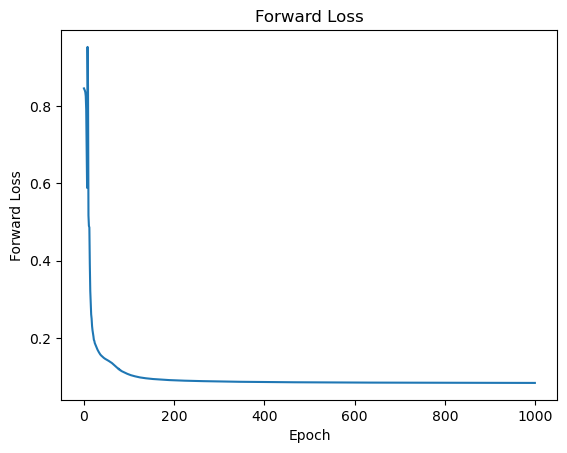

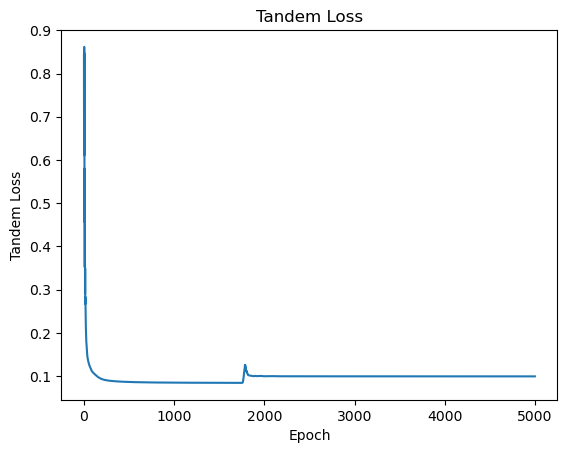

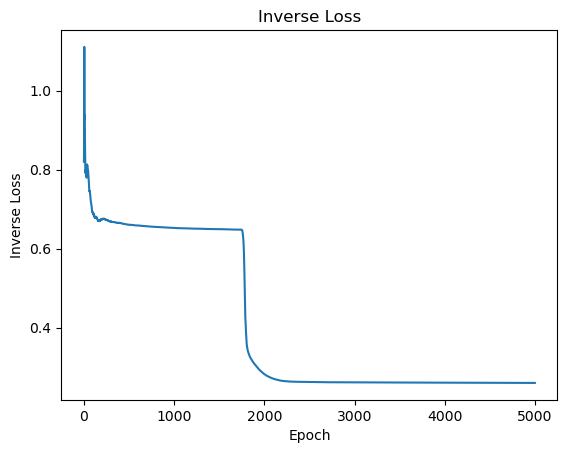

In [93]:
# plot forward loss
plt.plot(forward_loss_list)

plt.title("Forward Loss")
plt.xlabel("Epoch")
plt.ylabel("Forward Loss")
plt.show()


# plot tandem loss
plt.plot(tandem_loss_list)

plt.title("Tandem Loss")
plt.xlabel("Epoch")
plt.ylabel("Tandem Loss")
plt.show()

# plot inverse loss
plt.plot(inverse_loss_list)

plt.title("Inverse Loss")
plt.xlabel("Epoch")
plt.ylabel("Inverse Loss")
plt.show()

# Testing

In [94]:
pred_temp, pred_spec = tandem_net(spec_test)

In [95]:
# unscale data appropriately
pred_temp = temp_scaler.inverse_transform(pred_temp.detach().numpy())
pred_spec = spec_scaler.inverse_transform(pred_spec.detach().numpy())
spec_test = spec_scaler.inverse_transform(spec_test.detach().numpy())
temp_test = temp_scaler.inverse_transform(temp_test.detach().numpy())

In [96]:
pred_temp

array([[300.64053, 316.82846, 321.2557 , ..., 323.44177, 322.527  ,
        322.42224],
       [365.94974, 349.00906, 348.09006, ..., 340.26086, 344.51764,
        343.35025],
       [296.3577 , 329.4279 , 331.75937, ..., 319.51398, 313.48923,
        313.9557 ],
       ...,
       [300.67886, 305.22293, 312.69037, ..., 328.77374, 332.21423,
        368.56732],
       [299.17847, 299.08328, 295.50403, ..., 309.95828, 309.42947,
        326.21182],
       [296.1407 , 305.16925, 308.26947, ..., 343.09436, 355.27188,
        352.42966]], dtype=float32)

In [97]:
pred_spec

array([[0.01998839, 0.01619758, 0.02048222, ..., 2.3793712 , 2.3807557 ,
        2.366351  ],
       [0.05122459, 0.05109413, 0.0684242 , ..., 3.3282802 , 3.3187575 ,
        3.3339584 ],
       [0.02377148, 0.02052953, 0.02588706, ..., 2.0536644 , 2.0305743 ,
        2.0271316 ],
       ...,
       [0.02440855, 0.02190913, 0.02849109, ..., 4.854419  , 4.844379  ,
        4.8393493 ],
       [0.00930348, 0.00883638, 0.01304254, ..., 2.5442393 , 2.5369382 ,
        2.5519972 ],
       [0.02034446, 0.02127659, 0.03076935, ..., 3.8480177 , 3.8142698 ,
        3.817059  ]], dtype=float32)

In [98]:
temp_test

array([[289.90225, 327.36697, 334.1595 , ..., 324.3153 , 329.74402,
        320.20285],
       [364.35455, 358.1452 , 353.1166 , ..., 336.02835, 345.41626,
        343.54514],
       [283.05533, 313.427  , 332.78308, ..., 324.28024, 302.26672,
        315.4718 ],
       ...,
       [317.59354, 321.20697, 323.18884, ..., 320.77206, 343.04645,
        367.132  ],
       [289.43433, 308.9459 , 305.13788, ..., 308.75134, 319.20883,
        326.29092],
       [290.72708, 298.5739 , 308.86383, ..., 341.0469 , 356.98203,
        352.17227]], dtype=float32)

In [99]:
spec_test

array([[ 2.2715500e-02,  1.3124907e-03,  1.4554444e-02, ...,
         2.3195624e+00,  2.3139875e+00,  2.3087597e+00],
       [ 5.5705402e-02,  7.0714094e-02,  8.0661289e-02, ...,
         3.4005435e+00,  3.3752224e+00,  3.3564317e+00],
       [ 1.9306181e-02,  1.0375144e-02,  3.1374536e-02, ...,
         2.1273515e+00,  2.1168849e+00,  2.1154954e+00],
       ...,
       [ 2.0590343e-02,  7.6116975e-03,  2.9682815e-02, ...,
         4.7599277e+00,  4.7655878e+00,  4.7579808e+00],
       [-1.9664112e-02,  4.2241216e-03, -5.2194870e-03, ...,
         2.5903261e+00,  2.5670300e+00,  2.5588982e+00],
       [ 7.4147135e-03, -2.0453704e-03,  2.8540127e-02, ...,
         3.8685234e+00,  3.8686044e+00,  3.8456514e+00]], dtype=float32)

In [100]:
def plot_test_results(pred, actual, index):
    plt.figure(figsize=(15, 5))
    plt.title(f"Temperature Across Layers for Sample {index}")
    plt.xlabel("Layer")
    plt.ylabel("Temperature (K)")
    plt.plot(pred, 'ro', label='predicted')
    plt.plot(actual, 'b', label='actual')
    plt.legend()
    plt.show()

test_losses: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


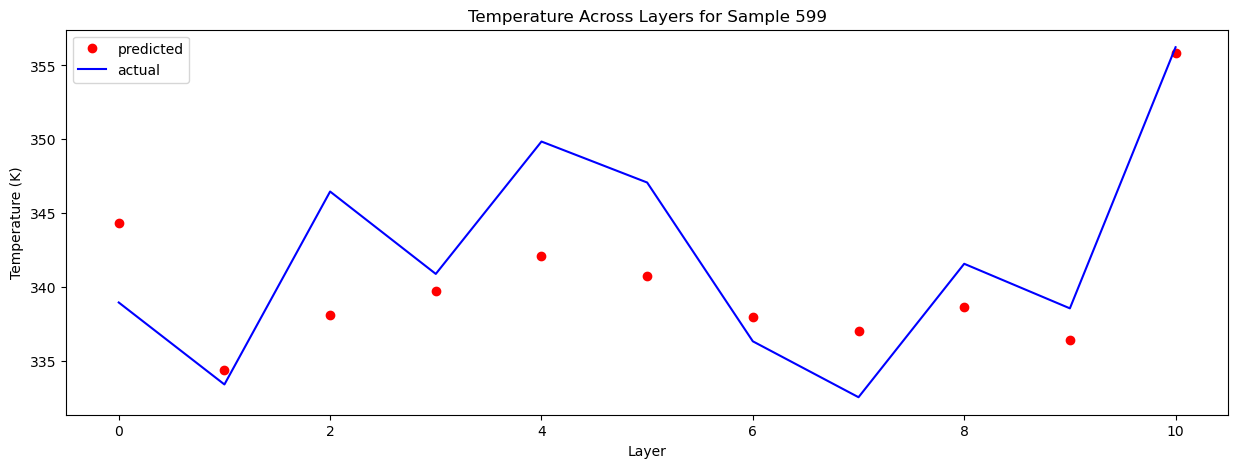

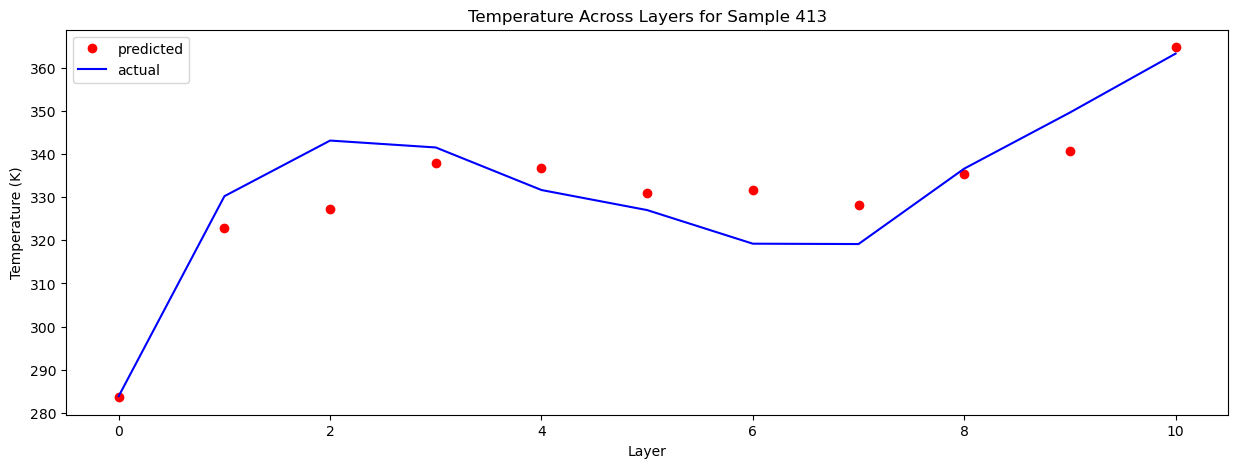

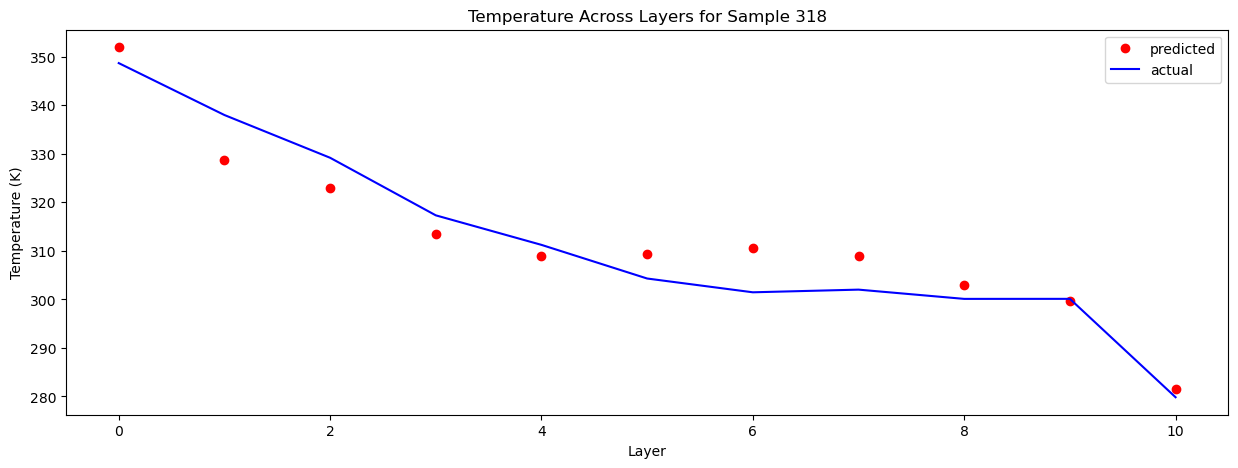

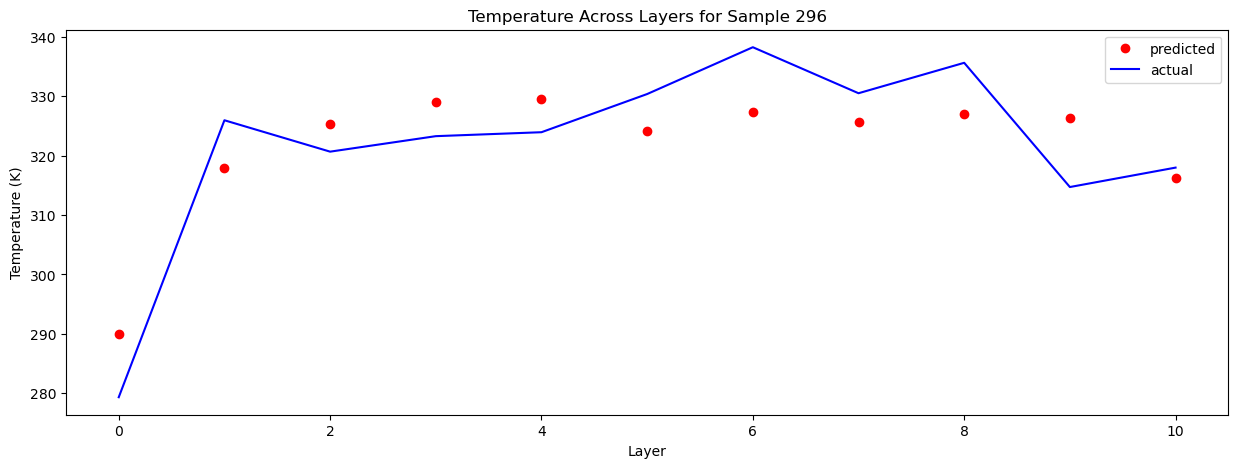

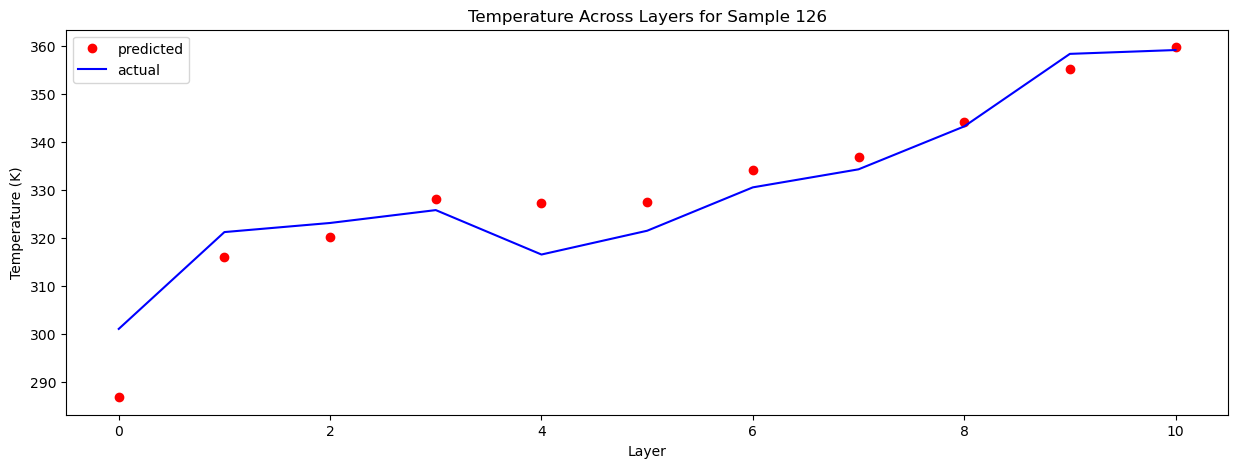

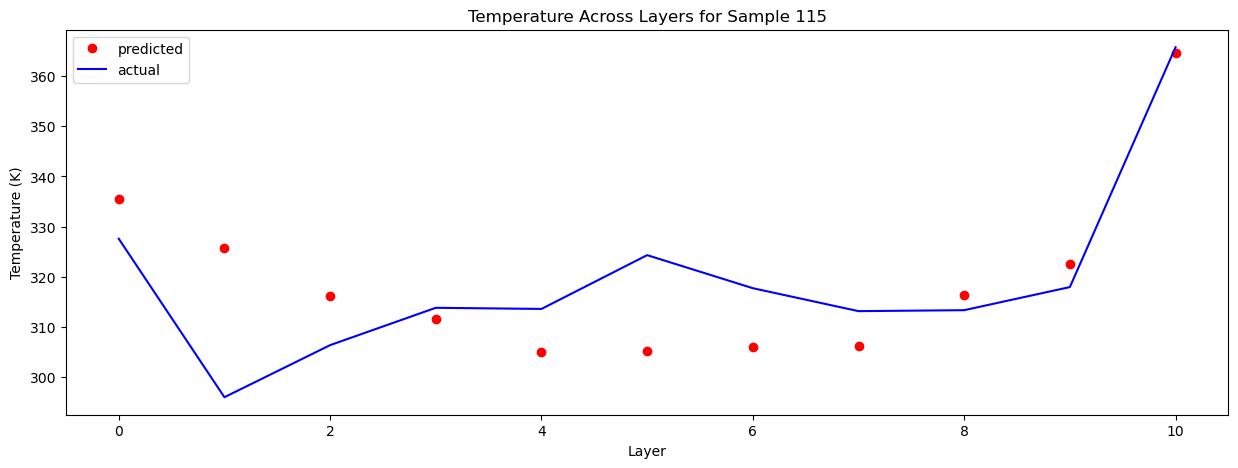

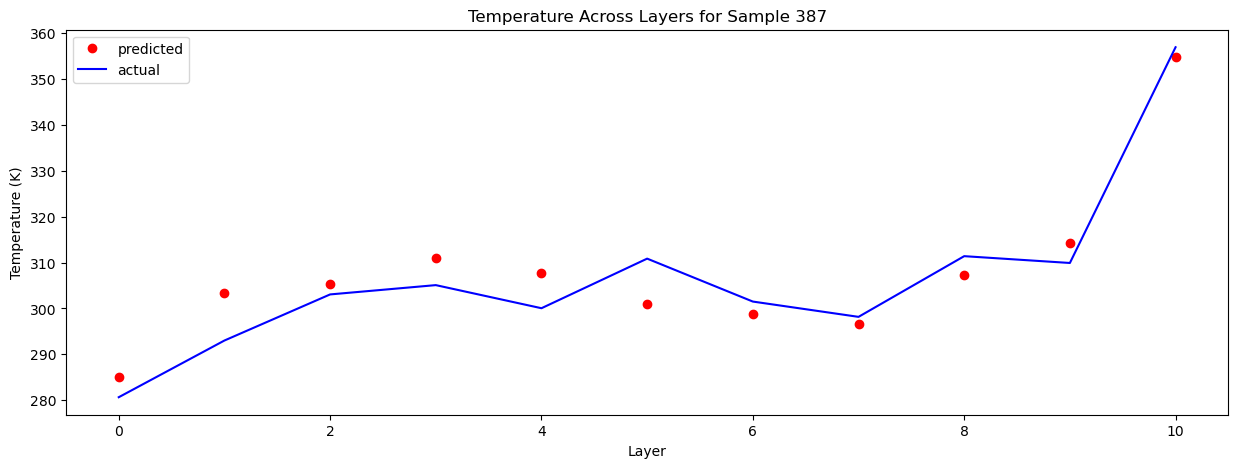

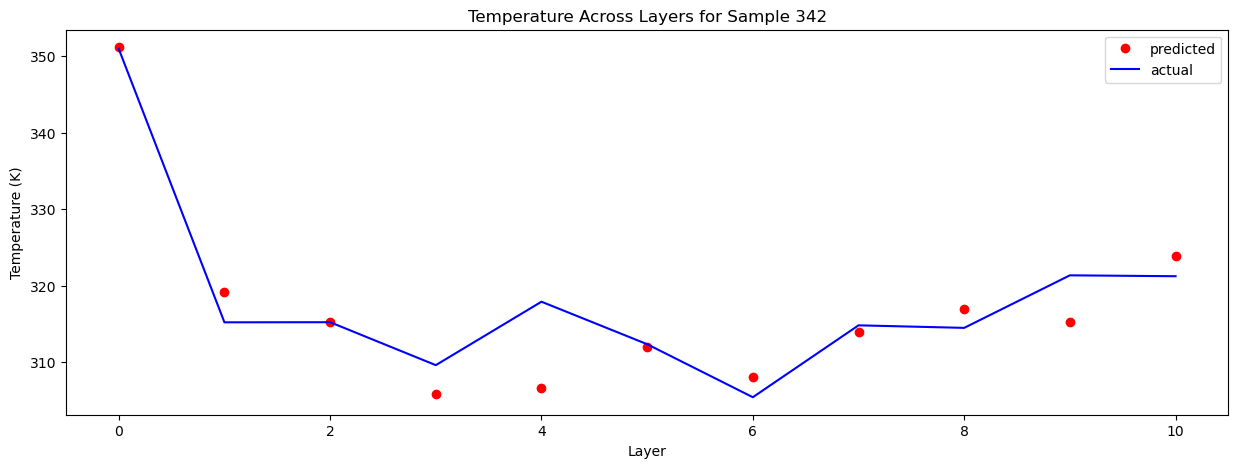

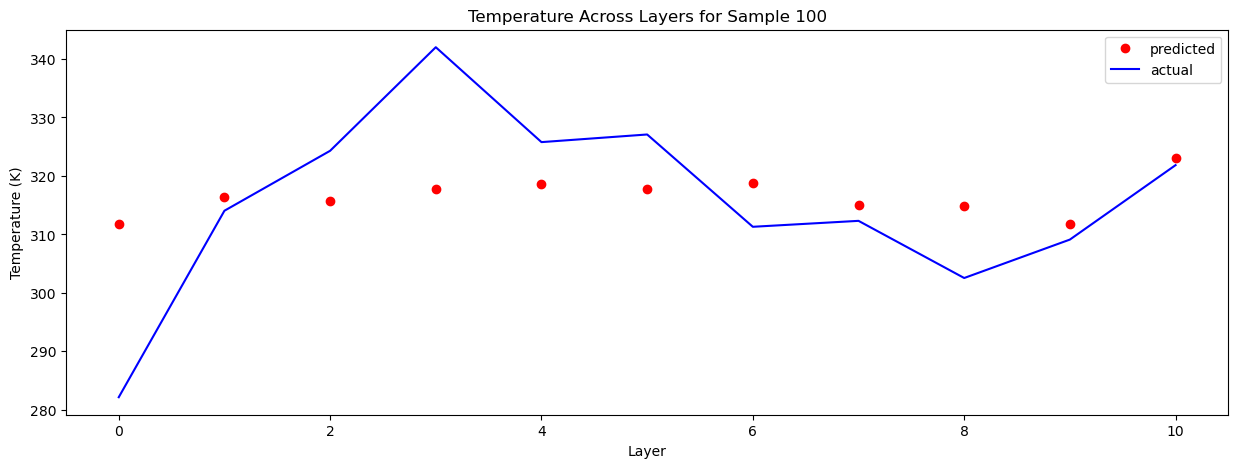

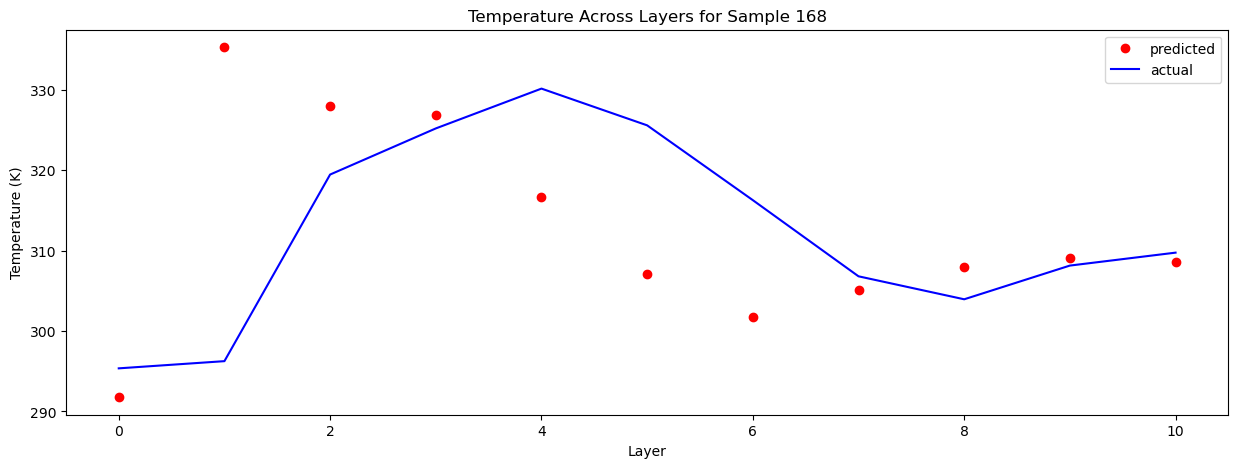

In [101]:
# plot spectrum --> temperature error
import random
num_graphs = 10
indices = []

test_losses = [0] * 11

with torch.no_grad():
    for i in range(len(pred_temp)):
    # sum loss for each entry
        for layer in range(len(pred_temp[0])):
            l1_loss = abs(pred_temp[i][layer] - pred_temp[i][layer]).item()
            test_losses[layer] += l1_loss

    # divide each loss by number of entries to find average loss per layer
    for i in range(len(test_losses)):
        test_losses[i] = test_losses[i] / len(pred_temp)

    print(f'test_losses: {test_losses}')

    for i in range(0, num_graphs):
        n = random.randint(0, len(pred_temp))
        indices.append(n)

    for index in indices:
        plot_test_results(pred_temp[index], temp_test[index], index)


TypeError: only size-1 arrays can be converted to Python scalars

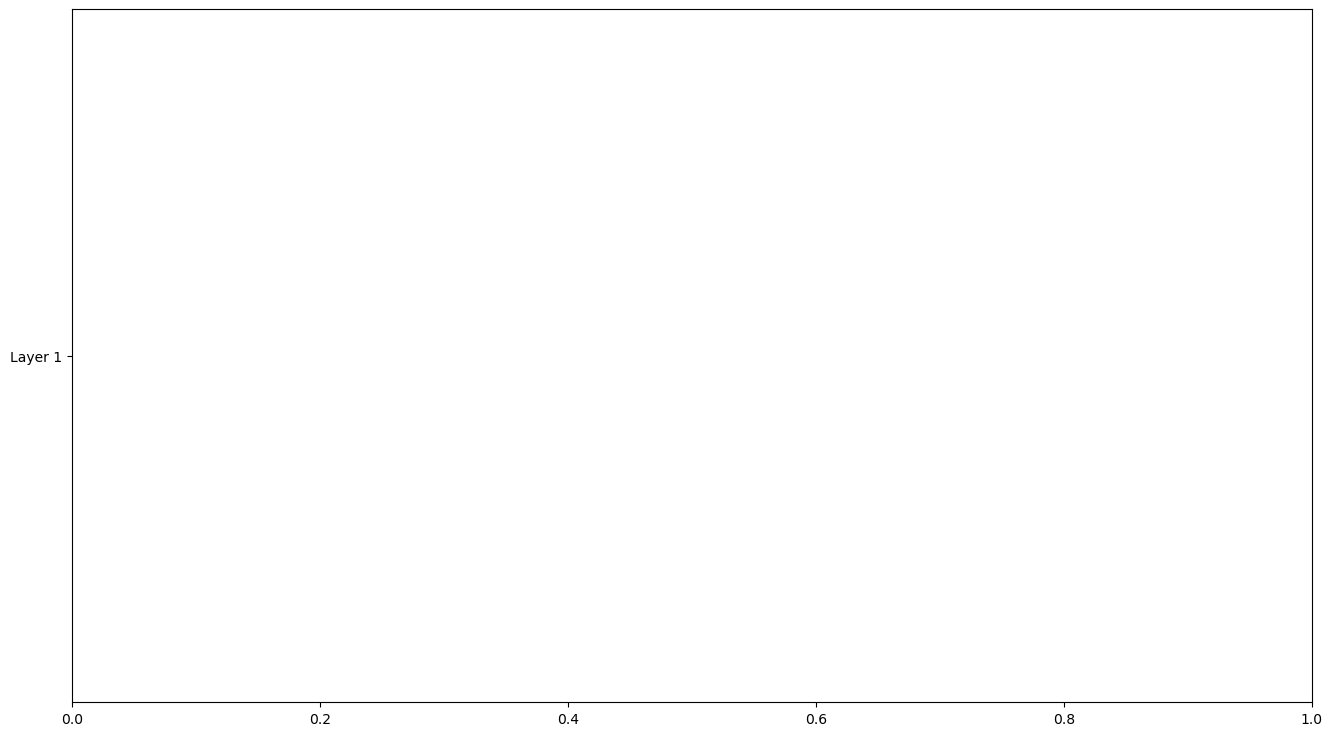

In [102]:
# Plotting the test losses per layer

# create list of layer names
layer_names = []
for i in range(1, 12):
    layer_names.append(f'Layer {i}')

fig, ax = plt.subplots(figsize =(16, 9))
ax.barh(layer_names, pred_temp)
 
# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
 
# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
 
# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)

# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='grey')

plt.title("Testing MAE Loss per Layer")
plt.xlabel("MAE Loss (K)")
plt.ylabel("Layer")

plt.show()